**IN PROGRESS**

## Import packages

In [1]:
from pathlib import Path
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from utils import check_integrity, load_data

## Data Integrity Check

Note: The number of all supported coins: 169

In [2]:
data_dir = Path(os.getcwd(), '..', 'data').resolve()
intervals = ['1D', '1W', '3h', '30m']
time_ranges = [("2021-01-11", "2021-03-15"), ("2021-08-16", "2021-10-18")]
coins_pass_check_1_3 = {}   # "2021-01-12" - "2021-03-14"
coins_pass_check_8_10 = {}  # "2021-08-15" - "2021-10-16"

for interval in intervals:
    coins_pass_check_1_3[interval] = []
    coins_pass_check_8_10[interval] = []
    data_interval_dir = Path(data_dir, interval)
    files_path_list = [p for p in data_interval_dir.iterdir() if p.suffix == '.csv']
    for file_path in files_path_list:
        coin_code = file_path.name.split("_")[0]
        if check_integrity(*time_ranges[0], file_path) is not None:
            coins_pass_check_1_3[interval].append(coin_code)
        if check_integrity(*time_ranges[1], file_path) is not None:
            coins_pass_check_8_10[interval].append(coin_code)


In [3]:
print(f'The number of coins having all the data from {time_ranges[0][0]} to {time_ranges[0][1]}:')
{k:len(v) for k, v in coins_pass_check_1_3.items()}

The number of coins having all the data from 2021-01-11 to 2021-03-15:


{'1D': 73, '1W': 93, '3h': 46, '30m': 35}

In [4]:
print(f'The number of coins having all the data from {time_ranges[1][0]} to {time_ranges[1][1]}:')
{k:len(v) for k, v in coins_pass_check_8_10.items()}

The number of coins having all the data from 2021-08-16 to 2021-10-18:


{'1D': 117, '1W': 130, '3h': 3, '30m': 0}

**==>** Small granularity data has a large number of missing entries.

In [5]:
print(f'The number of coins having complete 1D data in both periods :')
coins = list(set(coins_pass_check_1_3['1D']).intersection(set(coins_pass_check_8_10['1D'])))
len(coins)

The number of coins having complete 1D data in both periods :


70

The following analysis will only focus on these coins.

The missing values of these coins will be filled with linear interpolation.

## Load data for further analysis

In [87]:
data_path = "../data"

data_1D_1_3_list = []
data_1D_8_10_list = []
interval = '1D'

for coin in coins:
    file_path = Path(data_path, interval, f"{coin}_USD_{interval}.csv").resolve()
    data_1D_1_3_list.append(load_data(time_ranges[0][0], time_ranges[0][1], file_path, fill_na=True))
    data_1D_8_10_list.append(load_data(time_ranges[1][0], time_ranges[1][1], file_path, fill_na=True))

data_1D_1_3 = pd.concat(data_1D_1_3_list)
data_1D_8_10 = pd.concat(data_1D_8_10_list)


## Time Series Visualization

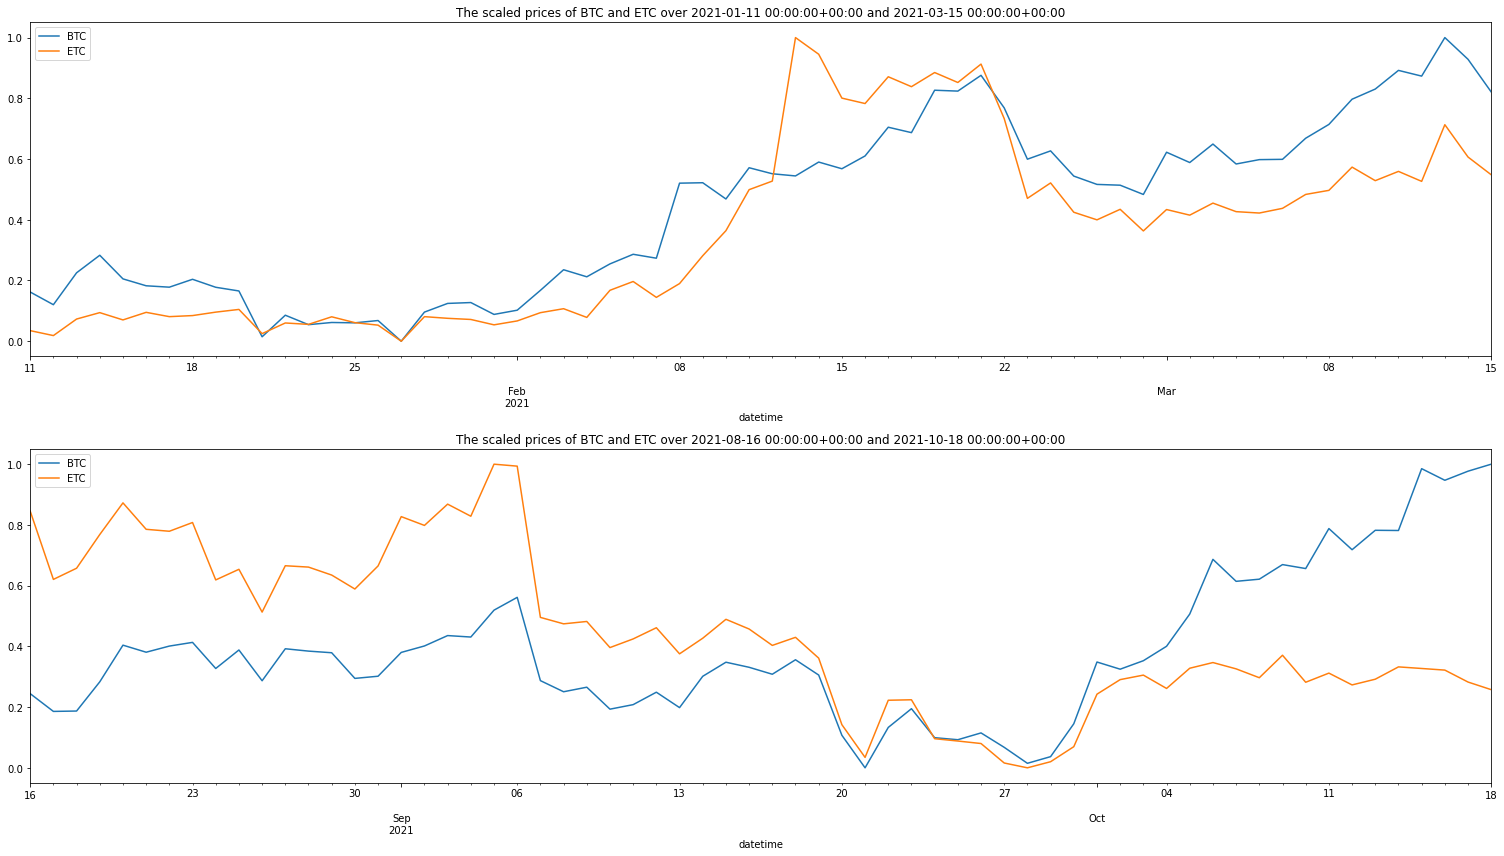

In [139]:
fig, axs = plt.subplots(2, 1, figsize=(21, 12))
axs = axs.ravel()

plot_coins_num = 5
subplot_idx = 0
for df in [data_1D_1_3, data_1D_8_10]:
    for tick in ['BTC', 'ETC']:
        scaler = MinMaxScaler()
        _tmp_df = df[df.index.isin([tick], level='coin')].set_index('datetime').copy()
        _tmp_df['price_std'] = scaler.fit_transform(_tmp_df[['close']])
        _tmp_df['price_std'].plot(label=tick, ax=axs[subplot_idx])
    axs[subplot_idx].legend()
    axs[subplot_idx].set_title(f'The scaled prices of BTC and ETC over {min(df.datetime)} and {max(df.datetime)}')
    subplot_idx += 1
    
fig.tight_layout()
plt.show()

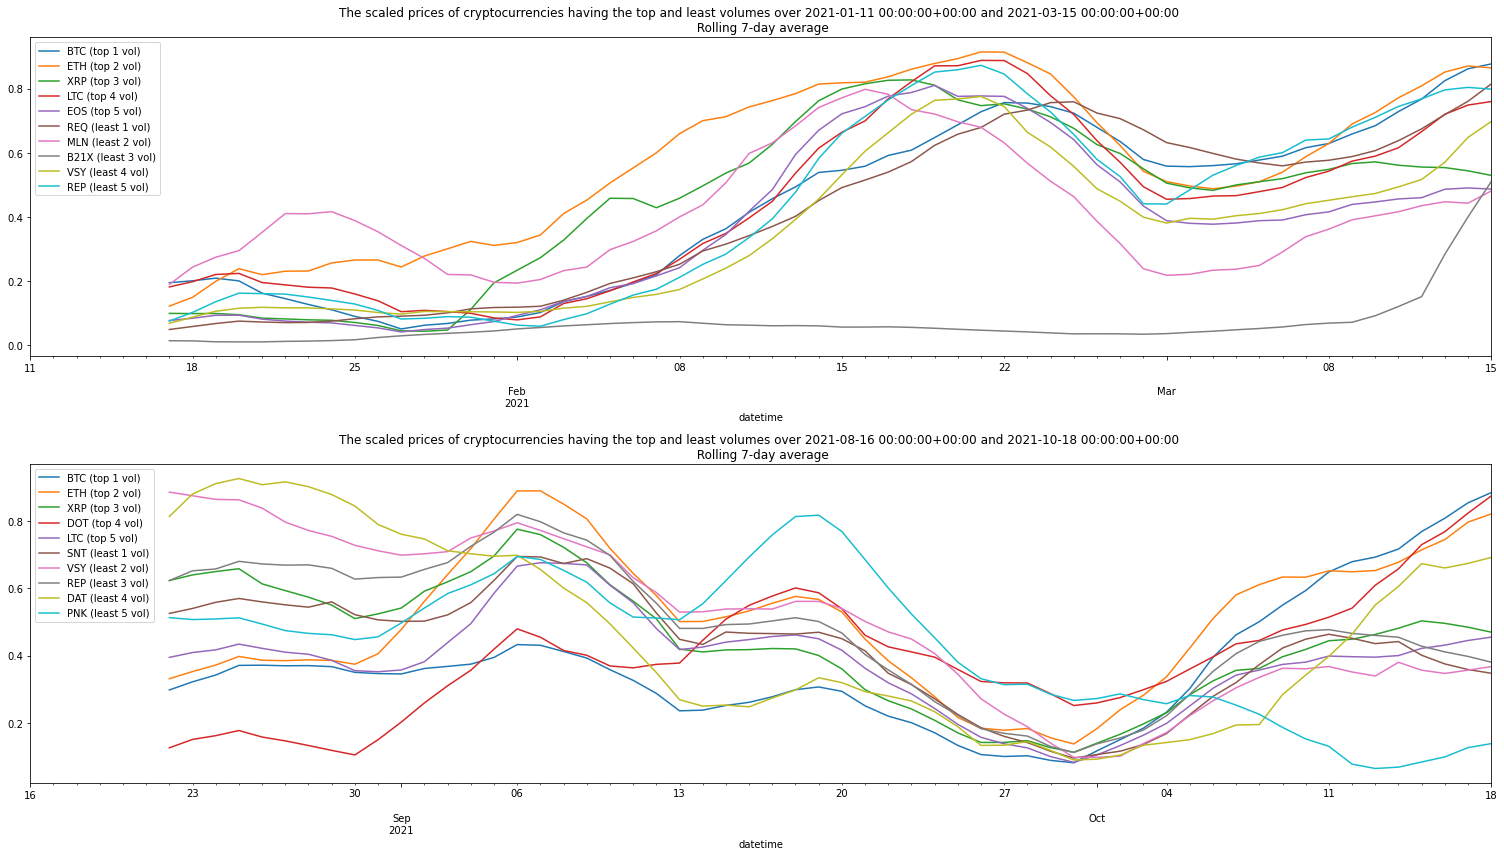

In [132]:
fig, axs = plt.subplots(2, 1, figsize=(21, 12))
axs = axs.ravel()

plot_coins_num = 5
subplot_idx = 0
for df in [data_1D_1_3, data_1D_8_10]:
    df['volumeUSD'] = df['volume'] * df['close']
    top_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=False).index[:plot_coins_num]
    least_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=True).index[:plot_coins_num]
    for idx, tick in enumerate(top_vol):
        scaler = MinMaxScaler()
        _tmp_df = df[df.index.isin([tick], level='coin')].set_index('datetime').copy()
        _tmp_df['price_std'] = scaler.fit_transform(_tmp_df[['close']])
        _tmp_df['price_std'].rolling(window=7).mean().plot(label=tick+f" (top {idx+1} vol)", ax=axs[subplot_idx])
    for idx, tick in enumerate(least_vol):
        scaler = MinMaxScaler()
        _tmp_df = df[df.index.isin([tick], level='coin')].set_index('datetime').copy()
        _tmp_df['price_std'] = scaler.fit_transform(_tmp_df[['close']])
        _tmp_df['price_std'].rolling(window=7).mean().plot(label=tick+f" (least {idx+1} vol)", ax=axs[subplot_idx])
    axs[subplot_idx].legend()
    axs[subplot_idx].set_title(f'The scaled prices of cryptocurrencies having the top and least volumes over {min(df.datetime)} and {max(df.datetime)} \n Rolling 7-day average')
    subplot_idx += 1
fig.tight_layout()
plt.show()